In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt

from tqdm import trange, tqdm
from IPython import display

from Tracking_LQR import generate_control, LQR_tracking_gain, PlanarQuadrotor
from quad_animation import animate_2D_quad
from Quadcopter import SymbolicFuncs
from rd_learner import RDLearner

In [2]:
# constants
dt = 0.01  # integration step
N = 8      # number of states
M = 2      # number of controls

In [3]:
sym_funcs = SymbolicFuncs()
f_full = sym_funcs["f_full"]

## Generate Control Law

In [4]:
rotor = PlanarQuadrotor(m_Q=2., Iyy=0.01, d=0.25, m_p=0.)
K = LQR_tracking_gain(np.zeros(6), dt, rotor)
get_control = functools.partial(generate_control, K=K, quad=rotor)

## Simulate

In [141]:
# random waypoint generation
np.random.seed(42)
num_wp = 16
wp_dt = 150
num_steps = num_wp * wp_dt
ts = np.arange(num_steps) * dt

goal_t6 = np.zeros((num_steps, 6))
for i in range(num_wp):
    x, y = np.random.uniform(-3, 3, size=2)
    goal_t6[i*wp_dt:(i+1)*wp_dt] = [x, y, 0, 0, 0, 0]

In [147]:
# noisy params
R_scale = np.array([.3, .3, .05, .09, .3, .3, .3, .3])

In [148]:
# initial state starting at origin
states = np.zeros((num_steps, N))
controls = np.zeros((num_steps, M))

In [149]:
for i in trange(1, num_steps):
    # 8-state to 6-state
    state_6 = states[i-1][[0, 1, 2, 4, 5, 6]]
    controls[i-1] = get_control(state_6, goal_t6[i]).flatten()
    states[i] = f_full(states[i-1], controls[i-1]).flatten()
measures = states + np.random.normal(scale=R_scale, size=(num_steps, R_scale.shape[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2399/2399 [00:00<00:00, 32635.36it/s]


In [150]:
_, anim = animate_2D_quad(ts, states, frameDelay=10)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

In [134]:
_, anim = animate_2D_quad(ts, measures, frameDelay=10)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

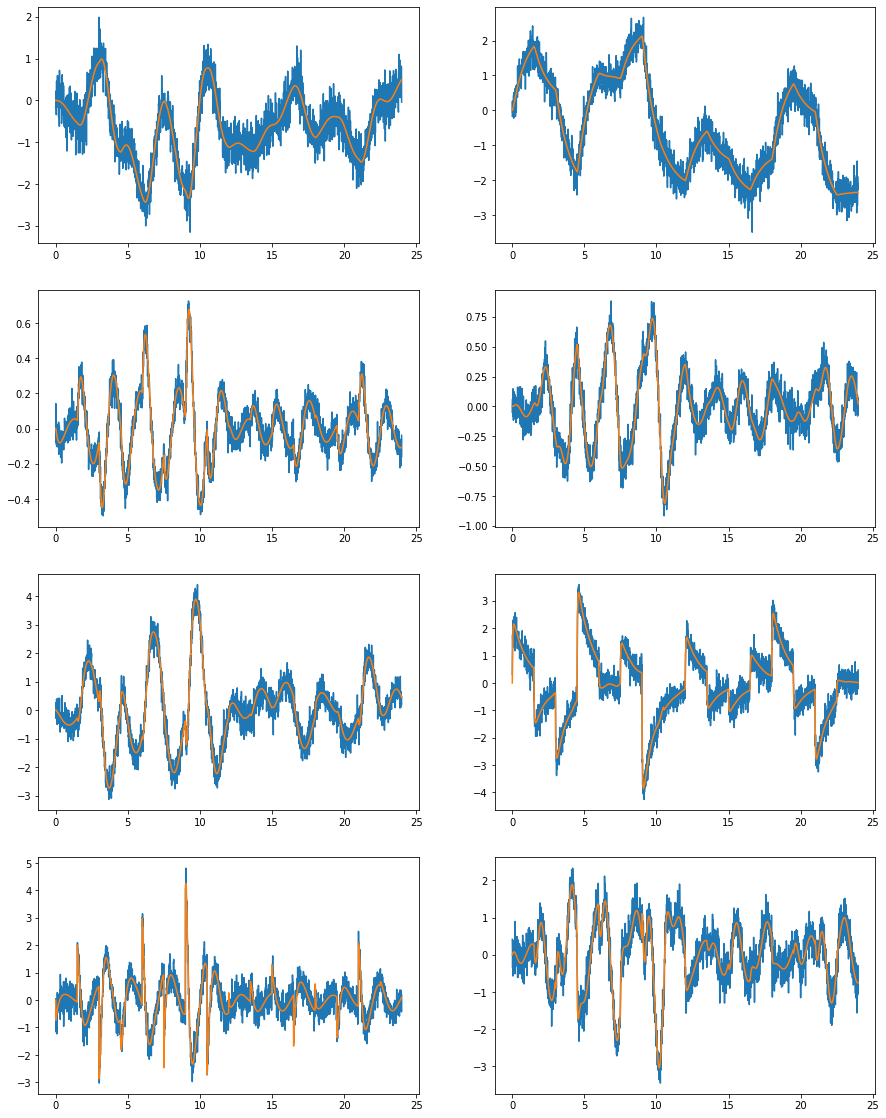

In [151]:
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(ts, measures[:, i])
    plt.plot(ts, states[:, i])

## Dynamics Learning

In [152]:
from importlib import reload
import rd_learner

rd_learner = reload(rd_learner)

In [153]:
# nominal dynamics rapper
f_un = sym_funcs["f_un"]
f_nominal = lambda x, u: f_un(x, u).flatten()

In [154]:
rdl = rd_learner.RDLearner(state_dim=8, control_dim=2, nominal_model=f_nominal, num_induced_points=40, batch_size=100)

In [155]:
rdl.add_data(states, controls)

In [156]:
rdl.model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
SVGP.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
SVGP.kernel.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].kernels[0].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
SVGP.kernel.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[3].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0


Start optimizing with existing data buffer...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:07<00:00, 15.70it/s]


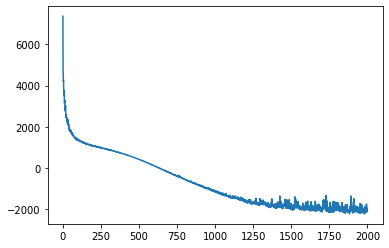

In [157]:
plt.plot(rdl.optimize(2000, adam_lr=1e-2, nat_lr=1e-2))

In [162]:
states_gt_tn = np.zeros_like(states)
states_nominal_tn = np.zeros_like(states)
states_est_tn = np.zeros_like(states)
VIZ_STEP = 500

for i in trange(1, VIZ_STEP):
    # 8-state to 6-state
    state_6 = states_gt_tn[i-1][[0, 1, 2, 4, 5, 6]]
    control = get_control(state_6, goal_t6[i]).flatten()
    states_gt_tn[i] = f_full(states_gt_tn[i-1], control).flatten()
    
    states_nominal_tn[i] = f_un(states_nominal_tn[i-1], control).flatten()
    
    residual, _ = rdl.predict(states_est_tn[i-1], control)
    states_est_tn[i] = f_un(states_est_tn[i-1], control).flatten() + residual

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:21<00:00, 23.48it/s]


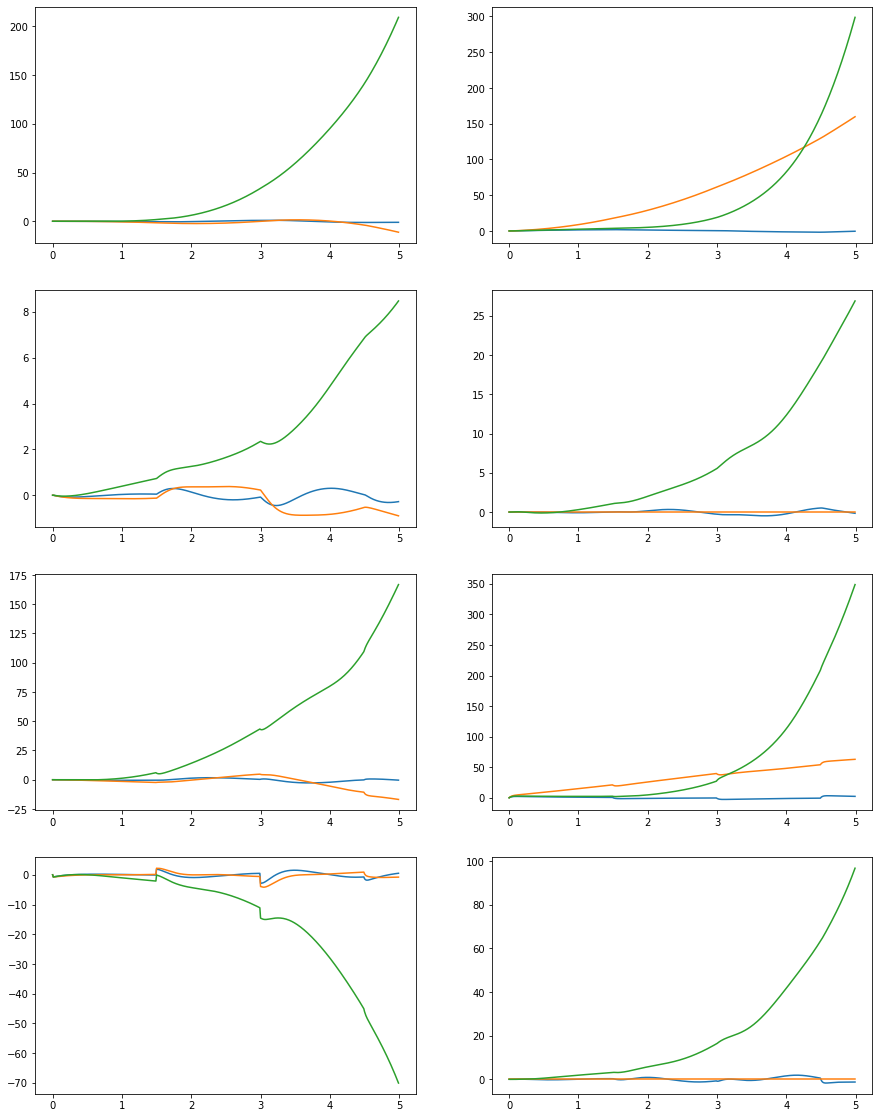

In [163]:
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(ts[:VIZ_STEP], states_gt_tn[:VIZ_STEP, i])
    plt.plot(ts[:VIZ_STEP], states_nominal_tn[:VIZ_STEP, i])
    plt.plot(ts[:VIZ_STEP], states_est_tn[:VIZ_STEP, i])

In [158]:
res_actual = f_full(states[100], controls[100]) - f_un(states[100], controls[100])
res_actual = res_actual.flatten()

In [159]:
res_pred, cov = rdl.predict(states[100], controls[100])

In [160]:
res_actual - res_pred

<tf.Tensor: shape=(8,), dtype=float64, numpy=
array([ 2.44884053e-05,  3.82462029e-05, -2.08734678e-03,  6.47383285e-03,
        1.51457743e-03, -5.34632280e-03,  4.62500820e-04, -1.29651034e-02])>

In [161]:
np.diag(cov)

array([2.63402542e-10, 2.02229268e-09, 9.74835097e-07, 3.65372228e-05,
       2.31138045e-06, 2.62560785e-05, 1.79431570e-05, 1.09032470e-04])